In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
import xarray as xr
from pyrealm.pmodel import PModel, PModelEnvironment
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import generic_filter
from pyrealm.pmodel import PModel, PModelEnvironment, AcclimationModel, SubdailyPModel
from pyrealm.pmodel.optimal_chi import OptimalChiPrentice14



# Load WRF dataset
day = 27
wrf_path = f"/scratch/c7071034/DATA/WRFOUT/WRFOUT_ALPS_1km/wrfout_d02_2012-07-{day:02d}_15:00:00"
wrf_ds = xr.open_dataset(wrf_path)
scaling_factor = 2/3 # # Scaling factor for the Pmodel calculation

# Load variables from WRF dataset 
temp = wrf_ds["T2"].to_numpy() - 273.15  # Convert to Celsius
patm = wrf_ds["PSFC"].to_numpy()  # Pa
co2 = wrf_ds["CO2_BIO"].isel(bottom_top=0).to_numpy()  # ppmv
qvapor = wrf_ds["QVAPOR"].isel(bottom_top=0).to_numpy()  # Water vapor mixing ratio (kg/kg) at the surface level
psfc = wrf_ds["PSFC"].isel(Time=0).to_numpy()            # Surface pressure (Pa)
t2 = wrf_ds["T2"].isel(Time=0).to_numpy()                # Temperature at 2m (K)

# Calculate actual vapor pressure (ea) in kPa
ea = (qvapor * psfc) / (0.622 + qvapor)  # Pa 
# Calculate saturation vapor pressure (es) in kPa
es = 0.6108 * np.exp((17.27 * temp) / (temp + 237.3)) * 1000 # convert to Pa
# Calculate VPD
vpd = np.maximum(0, es - ea)  # Force non-negative VPD


# Load required variables from WRF dataset
vegfra = wrf_ds["VEGFRA"].to_numpy()   # Vegetation fraction (0 to 1)
albedo = wrf_ds["ALBEDO"].to_numpy()   # Albedo (0 to 1)
swdown = wrf_ds["SWDOWN"].to_numpy()   # Downward shortwave radiation (W/m^2)
ppfd = swdown * 2.0 # Shortwave radiation (W/m²) × 0.505 -> PAR (W/m²) × 4.57 -> 2.30785*x ~ PPFD (umol/m²/s)
xlat = wrf_ds["XLAT"].to_numpy()       # Latitude (degrees)
xlon = wrf_ds["XLONG"].to_numpy()      # Longitude (degrees)
xlat = xlat[0, :,:]
xlon = xlon[0, :,:]
fapar_wrf = (1 - 0.5*albedo) * (vegfra/100)  # Calculate fAPAR

# get modis fpar /scratch/c7071034/DATA/MODIS/MODIS_FPAR/gap_filled/
modis_path = f"/scratch/c7071034/DATA/MODIS/MODIS_FPAR/gap_filled/fpar_interpol/interpolated_fpar_1km_2012-07-{day:02d}T12:00:00.nc"
modis_ds = xr.open_dataset(modis_path)
Lai_500m_scale_factor = 0.1
fpar_modis = modis_ds["FAPAR"].to_numpy() * Lai_500m_scale_factor  # fAPAR from MODIS
# where modis is nan use values from fapar_wrf
fpar_modis_gapfilled = np.where(np.isnan(fpar_modis), fapar_wrf, fpar_modis) # TODO: how is this handled in literature? There is no fPAR Data around cities, so these areas could also be masked out, but I would habe to modify the landcover maps... 

# Flatten the arrays for scatter plot
modis_flat = fpar_modis[0, :, :].flatten() * 100
wrf_flat = fapar_wrf[0, :, :].flatten() * 100

# Remove NaN values for a valid scatter plot
valid_mask = ~np.isnan(modis_flat) & ~np.isnan(wrf_flat)
modis_flat = modis_flat[valid_mask]
wrf_flat = wrf_flat[valid_mask]

# Sanitize inputs
temp[temp < -25] = np.nan
vpd = np.clip(vpd, 0, np.inf)

# Create environment with full inputs
pm_env = PModelEnvironment(
    tc=temp,
    co2=co2,
    patm=patm,
    vpd=vpd,
    fapar=fpar_modis,
    ppfd=ppfd
)

pm_env.summarize()

# Estimate productivity (automatically on init)
model = PModel(    
    env=pm_env,
    method_kphio="fixed",
    method_optchi="prentice14",)
#model.estimate_productivity(fapar=fapar_array, ppfd=ppfd_array)
model.summarize()
# Get the GPP
gpp = model.gpp


gC_to_mumol = 0.0833 # 1 µg C m⁻² s⁻¹ × (1 µmol C / 12.01 µg C) × (1 µmol CO₂ / 1 µmol C) = 0.0833 µmol CO₂ m⁻² s⁻¹
gpp_pmodel = model.gpp[0, :, :] * gC_to_mumol # * scaling_factor

STD_TOPO = 100 # Standard deviation threshold for topography
stdh_topo_3km = wrf_ds["VAR"].to_numpy()    # Standard deviation of the subgrdscale topography
land_mask = wrf_ds["LANDMASK"].to_numpy()  # Landmask (1 = land, 0 = water)
hgt = wrf_ds["HGT"].to_numpy()  # Terrain height
stdh_mask = stdh_topo_3km < STD_TOPO
mask = land_mask * stdh_mask
gpp_pmodel = np.where(mask, np.nan, gpp_pmodel)
hgt = np.where(mask, np.nan, hgt)

wrf_gpp = wrf_ds["EBIO_GEE"].isel(Time=0).to_numpy() 
wrf_gpp *= -1/3600 # mol km-2 h-1 -> mircro mol m-2 s-1
def nanmean_filter(values):
    return np.nanmean(values)
# wrf_gpp_filtered = generic_filter(wrf_gpp, nanmean_filter, size=3, mode='constant', cval=np.nan)
wrf_gpp_filtered = wrf_gpp
wrf_gpp_filtered = np.where(np.isnan(wrf_gpp), wrf_gpp_filtered, wrf_gpp)
wrf_gpp_filtered = np.where(mask, np.nan, wrf_gpp_filtered)
# Assuming wrf_gpp, model.gpp, gC_to_mumol, xlon, xlat are defined earlier
gpp_diff = wrf_gpp_filtered - gpp_pmodel

# sum up the differences
wrf_gpp_filtered_sum = np.nansum(wrf_gpp_filtered[0,:,:]) 
gpp_pmodel_sum = np.nansum(gpp_pmodel[0,:,:])
gpp_percent = (-gpp_pmodel_sum + wrf_gpp_filtered_sum) / gpp_pmodel_sum * 100
gpp_diff_sum = np.nansum(gpp_diff[0,:,:])
print(f"WRF GPP sum: {wrf_gpp_filtered_sum} µmol CO2 m-2 s-1")
print(f"P Model GPP sum: {gpp_pmodel_sum} µmol CO2 m-2 s-1")
print(f"GPP difference sum: {gpp_diff_sum} µmol CO2 m-2 s-1")
print(f"GPP difference percent: {gpp_percent} %")

PModelEnvironment(shape=(1, 327, 327))
Attr           Mean       Min        Max    NaN  Units
---------  --------  --------  ---------  -----  ------------
tc            24.78      2.52      39.56      0  °C
vpd         1741.49      0       5048.08      0  Pa
co2          383.06    342.78     410.95      0  ppm
patm       89764.6   66356.2   101215         0  Pa
fapar          0.68      0          0.94      0  -
ppfd        1200.72     33.91    1388.14      0  µmol m-2 s-1
ca            34.39     25.69      40.36      0  Pa
gammastar      4.03      0.82       8.74      0  Pa
kmm           75.05      7.84     246.33      0  Pa
ns_star        1.02      0.74       1.85      0  -
PModel(shape=(1, 327, 327), method_optchi=prentice14, method_arrhenius=simple, method_jmaxlim=wang17, method_kphio=fixed)
Attr       Mean    Min     Max    NaN  Units
-------  ------  -----  ------  -----  ------------
lue        0.48   0.17    0.88      0  g C mol-1
iwue      70.28  -0     106         0  µmol mol

pyrealm/pmodel.py:409: UserWarning: 
    Pyrealm 2.0.0 uses a new default for the quantum yield of photosynthesis (phi0=1/8).
    You may need to change settings to duplicate results from pyrealm 1.0.0.
            


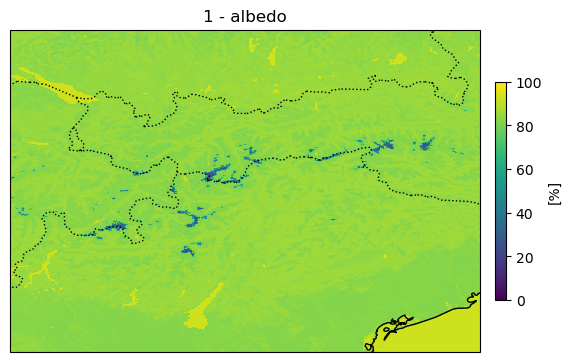

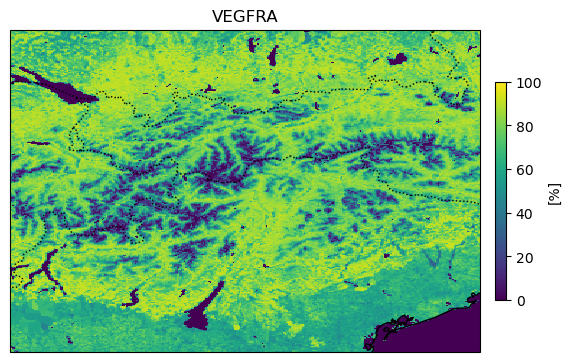

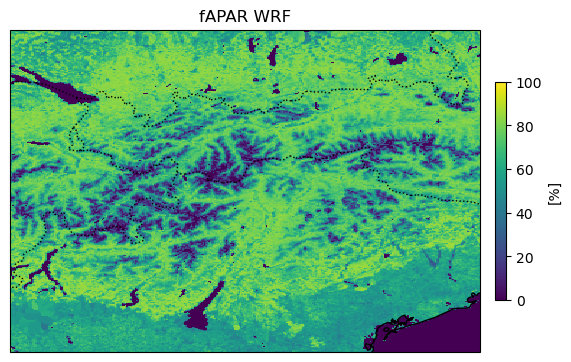

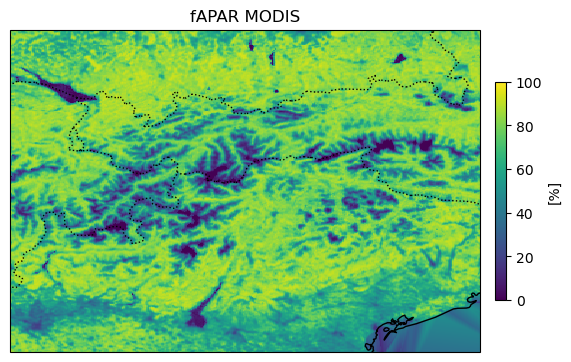

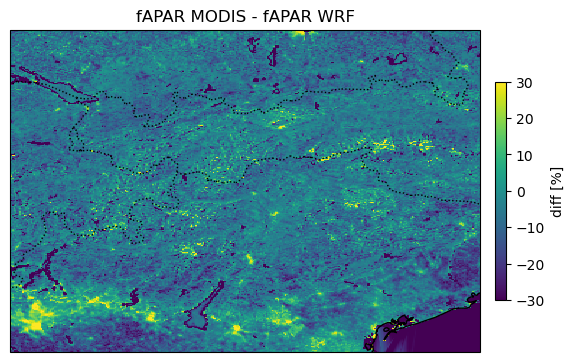

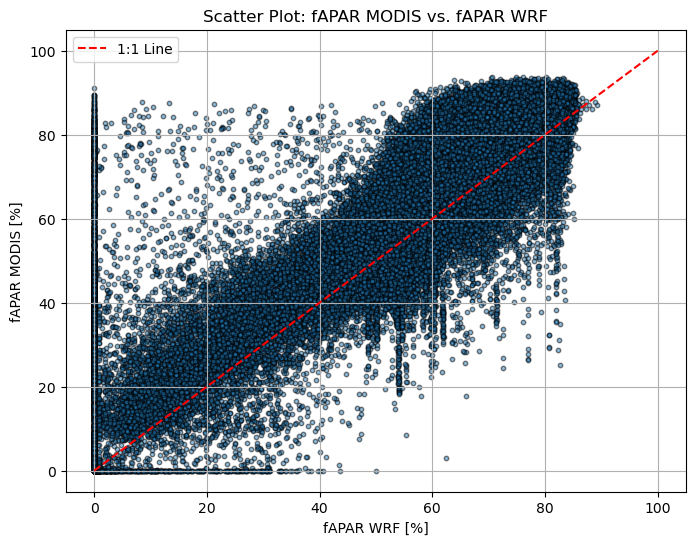

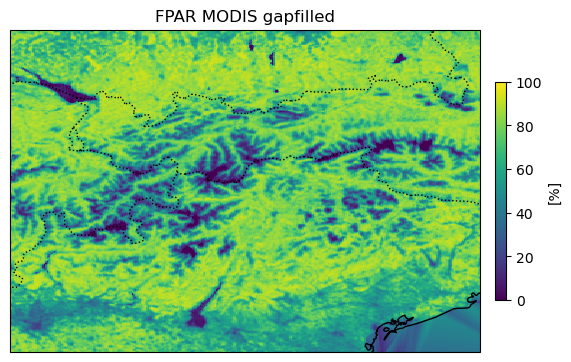

In [ ]:
# 1 - albedo
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=100)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, (1 - albedo[0, :, :])*100, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'[%]')
plt.title("1 - albedo")
plt.show()
# save fig 
fig.savefig(
    f"../plots/albedo_3km_2012-07-{day:02d}T12:00:00.png",
    dpi=300,
    bbox_inches="tight",
)
# vegfra 
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=100)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, vegfra[0, :, :], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'[%]')
plt.title("VEGFRA")
plt.show()
fig.savefig(
    f"../plots/VEGFRA_3km_2012-07-{day:02d}T12:00:00.png",
    dpi=300,
    bbox_inches="tight",
)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=100)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, fapar_wrf[0, :, :]*100, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'[%]')
plt.title("fAPAR WRF")
plt.show()
fig.savefig(
    f"../plots/fAPAR_WRF_3km_2012-07-{day:02d}T12:00:00.png",
    dpi=300,
    bbox_inches="tight",
)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=100)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, fpar_modis[0, :, :]*100, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label("[%]")
plt.title("fAPAR MODIS")
plt.show()
fig.savefig(
    f"../plots/fAPAR_MODIS_3km_2012-07-{day:02d}T12:00:00.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=-30, vmax=30)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, fapar_wrf[0, :, :]*100-fpar_modis[0, :, :]*100, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'diff [%]')
plt.title("fAPAR MODIS - fAPAR WRF")
plt.show()
fig.savefig(
    f"../plots/fAPAR_MODIS_WRF_3km_2012-07-{day:02d}T12:00:00.png",
    dpi=300,
    bbox_inches="tight",
)


# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(wrf_flat, modis_flat, alpha=0.5, edgecolor='k', s=10)
plt.xlabel("fAPAR WRF [%]")
plt.ylabel("fAPAR MODIS [%]")
plt.title("Scatter Plot: fAPAR MODIS vs. fAPAR WRF")
plt.grid(True)
plt.plot([0, 100], [0, 100], color='red', linestyle='--', label='1:1 Line')  # Add 1:1 line
plt.legend()
plt.savefig(
    f"../plots/scatter_fapar_3km_2012-07-{day:02d}T12:00:00.png",
    dpi=300,
    bbox_inches="tight",
)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=100)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, fpar_modis_gapfilled[0, :, :]*100, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label("[%]")
plt.title("FPAR MODIS gapfilled")
plt.show()
# save fig 
fig.savefig(
    f"../plots/FPAR_MODIS_gapfilled_3km_2012-07-{day:02d}T12:00:00.png",
    dpi=300,
    bbox_inches="tight",
)


PModelEnvironment(shape=(1, 327, 327))
Attr           Mean       Min        Max    NaN  Units
---------  --------  --------  ---------  -----  ------------
tc            24.78      2.52      39.56      0  °C
vpd         1741.49      0       5048.08      0  Pa
co2          383.06    342.78     410.95      0  ppm
patm       89764.6   66356.2   101215         0  Pa
fapar          0.68      0          0.94      0  -
ppfd        1385.54     39.13    1601.81      0  µmol m-2 s-1
ca            34.39     25.69      40.36      0  Pa
gammastar      4.03      0.82       8.74      0  Pa
kmm           75.05      7.84     246.33      0  Pa
ns_star        1.02      0.74       1.85      0  -


pyrealm/pmodel.py:409: UserWarning: 
    Pyrealm 2.0.0 uses a new default for the quantum yield of photosynthesis (phi0=1/8).
    You may need to change settings to duplicate results from pyrealm 1.0.0.
            


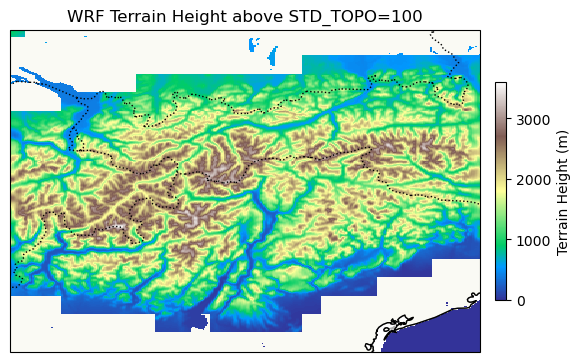

In [19]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)

# Use the 'terrain' colormap
terrain_cmap = plt.cm.terrain
terrain_norm = mcolors.Normalize(vmin=np.nanmin(hgt), vmax=np.nanmax(hgt))

mesh = ax.pcolormesh(xlon, xlat, hgt[0,:,:], cmap=terrain_cmap, norm=terrain_norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label('Terrain Height (m)')
plt.title(f"WRF Terrain Height above STD_TOPO={STD_TOPO}")
plt.show()


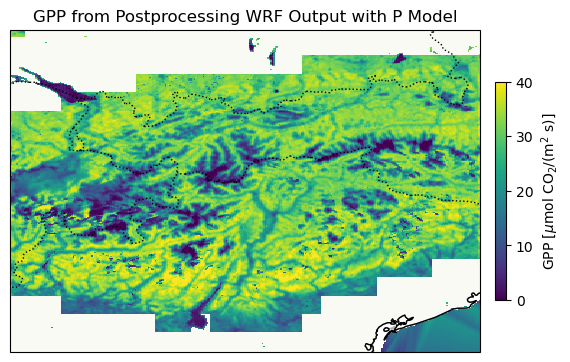

In [20]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=40)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, gpp_pmodel[0,:,:], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
plt.title("GPP from Postprocessing WRF Output with P Model")
plt.show()


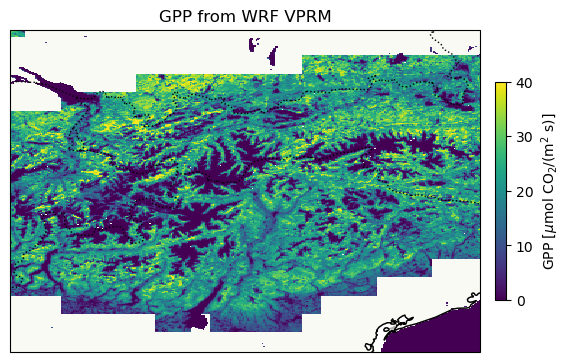

In [22]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', alpha=0.3)
cmap = plt.cm.viridis  # Use the 'viridis' colormap
norm = mcolors.Normalize(vmin=0, vmax=40)  # Set color limits (equivalent to clim)
mesh = ax.pcolormesh(xlon, xlat, wrf_gpp_filtered[0,:,:], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
plt.title("GPP from WRF VPRM")
plt.show()


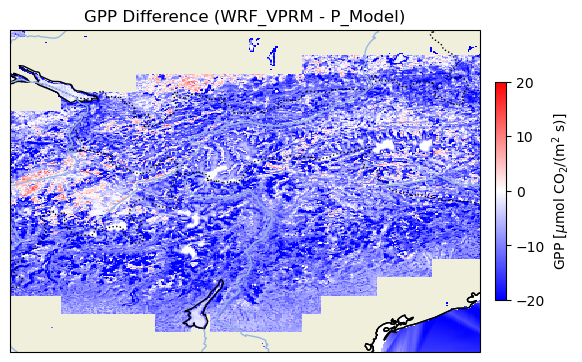

WRF GPP sum: 1313670.5 µmol CO2 m-2 s-1
P Model GPP sum: 2085524.8886424452 µmol CO2 m-2 s-1
GPP difference sum: -771247.0807636022 µmol CO2 m-2 s-1
GPP difference percent: -37.010078030997626 %


In [ ]:


# Create a map with a PlateCarree projection (a simple lat/lon projection)
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xlon.min(), xlon.max(), xlat.min(), xlat.max()], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS)
vmin, vmax = -20, 20
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.bwr
mesh = ax.pcolormesh(xlon, xlat, gpp_diff[0,:,:], cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.022, pad=0.03)
cbar.set_label(r'GPP [$\mu$mol CO$_2$/(m$^2$ s)]')
ax.set_title("GPP Difference (WRF_VPRM - P_Model)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show plot
plt.show()

